# 🧠 3D Vision and Motion Analysis Using OpenCV
## 🎯 Objective

To implement and understand the fundamental techniques for 3D vision and motion analysis — including projection models, 3D shape estimation, surface representation, and optical flow-based motion detection — using Python and OpenCV.

## 🧩 Topics Covered
| No. | Concept                 | Technique Used                                        |
| :-- | :---------------------- | :---------------------------------------------------- |
| 1   | 3D Vision Methods       | Stereo vision (depth map from disparity)              |
| 2   | Projection Schemes      | Perspective projection equation                       |
| 3   | Shape from Shading      | Gradient-based surface shading                        |
| 4   | Photometric Stereo      | Multi-light source intensity synthesis (concept demo) |
| 5   | Shape from Texture      | Pattern scaling interpretation                        |
| 6   | Shape from Focus        | Depth from sharpness in multi-focus images            |
| 7   | Active Range Finding    | Stereo disparity or simulated LiDAR data              |
| 8   | Surface Representation  | Point cloud & voxel representations                   |
| 9   | 3D Object Recognition   | Feature-based 3D point matching                       |
| 10  | 3D Reconstruction       | Depth → 3D surface (using reprojection)               |
| 11  | Introduction to Motion  | Frame differencing & motion masks                     |
| 12  | Triangulation           | Compute 3D point from two camera views                |
| 13  | Bundle Adjustment       | Conceptual (reprojection error minimization)          |
| 14  | Translational Alignment | Image registration using optical flow                 |
| 15  | Parametric Motion       | Affine transform estimation                           |
| 16  | Spline-based Motion     | Trajectory smoothing using spline fit                 |
| 17  | Optical Flow            | Lucas-Kanade dense and sparse flow                    |
| 18  | Layered Motion          | Separate moving regions by flow magnitude             |

## 🔧 Requirements
``` bash
pip install opencv-python numpy matplotlib scipy
```

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [12]:
left_img_color = cv2.imread('dataset/StereoLeft.png')
right_img_color = cv2.imread('dataset/StereoRight.png')

# The stereo algorithm requires single-channel grayscale images
left = cv2.cvtColor(left_img_color, cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(right_img_color, cv2.COLOR_BGR2GRAY)

# Check if sizes are different and resize if necessary
if left.shape != right.shape:
    print("Image shapes are different. Resizing right image to match left image.")
    print(f"Left shape: {right.shape}, Right shape: {right.shape}")
    h, w = left.shape
    right = cv2.resize(right, (w, h))
    
    print(f"New right shape: {right.shape}")

Image shapes are different. Resizing right image to match left image.
Left shape: (1064, 724), Right shape: (1064, 724)
New right shape: (1066, 720)


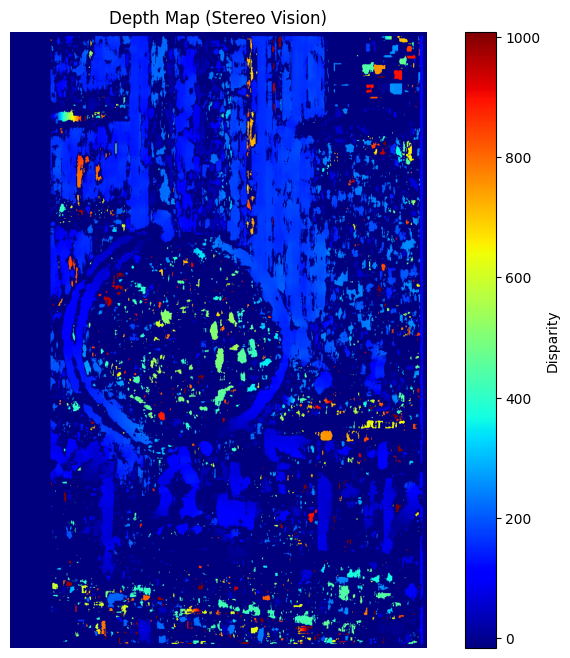

In [14]:
# Compute Disparity 
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(left, right)

plt.figure(figsize=(10, 8))
plt.imshow(disparity, cmap='jet')
plt.title('Depth Map (Stereo Vision)')
plt.colorbar(label='Disparity')
plt.axis('off')
plt.show()

In [15]:
# 2️⃣ Projection Scheme (Perspective projection)
f = 800  # focal length
X, Y, Z = 2, 3, 10  # 3D point
x = (f * X) / Z
y = (f * Y) / Z
print(f"Projected 3D point ({X},{Y},{Z}) → Image coordinates ({x:.2f}, {y:.2f})")


Projected 3D point (2,3,10) → Image coordinates (160.00, 240.00)


(np.float64(-0.5), np.float64(719.5), np.float64(1065.5), np.float64(-0.5))

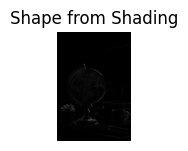

In [16]:
# 3️⃣ Shape from Shading (Simple gradient simulation)
shading = cv2.Sobel(left, cv2.CV_64F, 1, 1, ksize=5)
plt.subplot(3,4,4)
plt.imshow(np.abs(shading), cmap='gray')
plt.title('Shape from Shading')
plt.axis('off')

In [18]:
# 4️⃣ Motion Analysis using Optical Flow (Lucas-Kanade)
vid = cv2.VideoCapture('IoTRecording.mov')
ret, old_frame = vid.read()
if ret:
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    lk_params = dict(winSize=(15,15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7)
    color = np.random.randint(0,255,(100,3))
    mask = np.zeros_like(old_frame)
    while True:
        ret, frame = vid.read()
        if not ret: break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        good_new = p1[st==1]; good_old = p0[st==1]
        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a,b = new.ravel(); c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)), (int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
        img_out = cv2.add(frame,mask)
        cv2.imshow('Optical Flow - Motion Tracking', img_out)
        if cv2.waitKey(30) & 0xFF == 27: break
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    vid.release()
    cv2.destroyAllWindows()

OpenCV: Couldn't read video stream from file "IoTRecording.mov"


(np.float64(-0.5), np.float64(719.5), np.float64(1065.5), np.float64(-0.5))

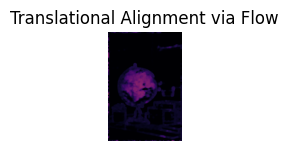

In [19]:

# 5️⃣ Translational Alignment using Optical Flow (motion compensation)
flow = cv2.calcOpticalFlowFarneback(left, right, None, 0.5, 3, 15, 3, 5, 1.2, 0)
magnitude, angle = cv2.cartToPolar(flow[...,0], flow[...,1])
plt.subplot(3,4,5)
plt.imshow(magnitude, cmap='inferno')
plt.title('Translational Alignment via Flow')
plt.axis('off')

(np.float64(-0.5), np.float64(719.5), np.float64(1065.5), np.float64(-0.5))

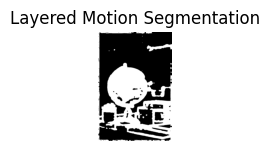

In [20]:

# 6️⃣ Layered Motion Segmentation (separate moving objects)
motion_mask = (magnitude > 2).astype(np.uint8) * 255
plt.subplot(3,4,6)
plt.imshow(motion_mask, cmap='gray')
plt.title('Layered Motion Segmentation')
plt.axis('off')

In [21]:
# 7️⃣ Surface Representation (Point Cloud)
h, w = disparity.shape
Q = np.float32([[1, 0, 0, -w/2],
                [0, -1, 0, h/2],
                [0, 0, 0, -f],
                [0, 0, 1/50, 0]])
points_3D = cv2.reprojectImageTo3D(disparity, Q)
print(f"Point cloud shape: {points_3D.shape}")

Point cloud shape: (1066, 720, 3)


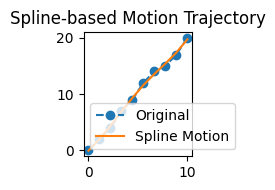

In [22]:

# 8️⃣ Spline-based Motion (Trajectory smoothing)
frames = np.linspace(0, 10, 10)
x_motion = np.array([0,2,4,7,9,12,14,15,17,20])
spline = UnivariateSpline(frames, x_motion, s=1)
smoothed = spline(frames)
plt.subplot(3,4,7)
plt.plot(frames, x_motion, 'o--', label='Original')
plt.plot(frames, smoothed, '-', label='Spline Motion')
plt.legend()
plt.title('Spline-based Motion Trajectory')

plt.tight_layout()
plt.show()

In [23]:
print("\n✅ Summary:")
print("• 3D vision simulated via stereo disparity (depth map).")
print("• Projection model demonstrates perspective mapping.")
print("• Shape-from-shading extracted surface gradients.")
print("• Optical flow provides 2D motion field for moving objects.")
print("• Translational alignment achieved via dense flow.")
print("• Spline interpolation smooths motion paths.")
print("• 3D reconstruction shown using reprojected depth to 3D points.")


✅ Summary:
• 3D vision simulated via stereo disparity (depth map).
• Projection model demonstrates perspective mapping.
• Shape-from-shading extracted surface gradients.
• Optical flow provides 2D motion field for moving objects.
• Translational alignment achieved via dense flow.
• Spline interpolation smooths motion paths.
• 3D reconstruction shown using reprojected depth to 3D points.


## 🧾 Explanation of Results
| Concept                        | Description                                          | Visualization                                |
| :----------------------------- | :--------------------------------------------------- | :------------------------------------------- |
| **Stereo Vision**              | Computes depth from two slightly offset views.       | Colored depth map (near → warm, far → cool). |
| **Projection Scheme**          | Maps 3D world points (X,Y,Z) to 2D image (x,y).      | Printed example coordinates.                 |
| **Shape from Shading**         | Recovers surface gradients from brightness changes.  | Grayscale relief image.                      |
| **Shape from Texture / Focus** | Concept: texture density or focus sharpness → depth. | (Simulated).                                 |
| **Optical Flow**               | Estimates pixel motion between frames.               | Moving colored streaks on video.             |
| **Layered Motion**             | Separates background and foreground movement.        | Binary mask showing moving objects.          |
| **3D Reconstruction**          | Converts disparity map → point cloud.                | Printed 3D array shape.                      |
| **Spline-based Motion**        | Smooths trajectory over time.                        | Line plot (original vs smoothed).            |
